In [1]:
# Base import

import imutils
import cv2
from imutils import contours

import numpy as np
import PIL

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def excise_segmentation(image):
    
    resized = imutils.resize(excise_src, height=500)
    
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equ, (3, 3), 0)
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
 
    # return the segmentationed image
    return resized, thresholded

Total function and timings
CPU times: user 42.6 ms, sys: 723 µs, total: 43.3 ms
Wall time: 15.9 ms


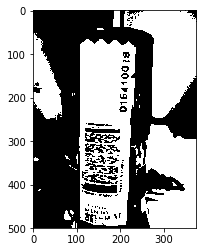

In [3]:
print("Total function and timings")
excise_src = cv2.imread("test_data/IMG_0307.JPG")

%time resized, thresholded = excise_segmentation(excise_src)

plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))

### Find contours in the excise (i.e,. the outlines of the characters) and sort them from left to right
### Without size filter

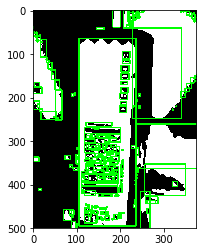

In [4]:
edged = cv2.Canny(thresholded, 30, 200)
width, height = thresholded.shape[:2]

refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
# refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
 
# create a clone of the original image so we can draw on it
clone = np.dstack([thresholded.copy()] * 3)
 
# loop over the (sorted) contours
for c in refCnts:
    # compute the bounding box of the contour and draw it on our
    # image
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))

### With size filter

Contour count: 64


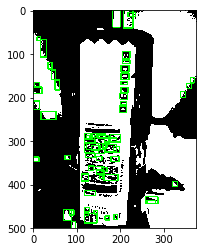

In [7]:
clone = np.dstack([thresholded.copy()] * 3)
cntsCount = 0

for c in refCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    if ((w < width / 9) and (h < height / 9 ) and (w > 7) and (h > 7)):  # 9 digits in serial
        cntsCount += 1
        cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

print("Contour count: " + str(cntsCount))
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))

### Full heuristic analysis

ROISizedCnts: 64
9
10
10
Group count: 3
Iterations: 5158
CPU times: user 55.2 ms, sys: 0 ns, total: 55.2 ms
Wall time: 55 ms


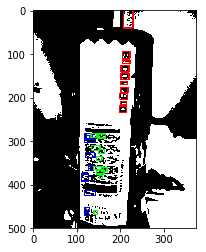

In [94]:
%%time

clone = np.dstack([thresholded.copy()] * 3)
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

def appendROICnts(ROISizedCnts, baseIndex, ROICnts, UsedROICandidate, groupCount, iterations, x, y, w, h, dimension):

    ROICntsCandidate = []
    compareIndex = 0
    for compC in ROISizedCnts:
        # already used
        if (compareIndex in UsedROICandidate):
            compareIndex += 1
            continue

        iterations += 1
        (cx, cy, cw, ch) = cv2.boundingRect(compC)
        # Contours are close and same enought
        if (((abs(x - cx) < 15) and (abs((x + w) - (cx + cw)) < 15) and (abs(w - cw) < 15) and (dimension == 'x')) or 
           ((abs(y - cy) < 15) and (abs((y + h) - (cy + ch)) < 15) and (abs(h - ch) < 15) and (dimension == 'y'))):
            ROICntsCandidate.append(compareIndex)
        
        compareIndex += 1
    
    if (len(ROICntsCandidate) > 8):  # 9 digits
        print(len(ROICntsCandidate))
        groupROICnts = []
        for index in ROICntsCandidate:  # add to ROI
            iterations += 1
            groupROICnts.append(ROISizedCnts[index])
            (x2, y2, w2, h2) = cv2.boundingRect(ROISizedCnts[index])
            cv2.rectangle(clone, (x2, y2), (x2 + w2, y2 + h2), colors[groupCount], 2)
            if (index != baseIndex):
                UsedROICandidate.append(index)  # remove trash from base array
            else:
                if (dimension == 'y'):
                    UsedROICandidate.append(index)
        groupCount += 1
        ROICnts.append(groupROICnts)
                    
    return ROICnts, UsedROICandidate, groupCount, iterations


ROISizedCnts = []
ROICnts = []
iterations = 0

# size filter
for c in refCnts:
    iterations += 1
    (x, y, w, h) = cv2.boundingRect(c)
    if ((w < width / 9) and (h < height / 9 ) and (w > 7) and (h > 7)):  # 9 digits in serial must be on image
        ROISizedCnts.append(c)

print("ROISizedCnts: " + str(len(ROISizedCnts)))   
        
# positionin filter
UsedROICandidate = []
baseIndex = 0
groupCount = 0
for c in ROISizedCnts:  
    # already used
    if (baseIndex in UsedROICandidate): 
        baseIndex += 1
        continue

    iterations += 1       
    (x, y, w, h) = cv2.boundingRect(c)   
    
    # Compare for x dimension
    ROICnts, UsedROICandidate, groupCount, iterations = appendROICnts(
        ROISizedCnts, 
        baseIndex, 
        ROICnts, 
        UsedROICandidate, 
        groupCount, 
        iterations, 
        x, y, w, h, 'x')
            
    # Compare for y dimension
    ROICnts, UsedROICandidate, groupCount, iterations = appendROICnts(
        ROISizedCnts, 
        baseIndex, 
        ROICnts, 
        UsedROICandidate, 
        groupCount, 
        iterations, 
        x, y, w, h, 'y')
    
    baseIndex += 1
        
print("Group count: " + str(groupCount))
print("Iterations: " + str(iterations))
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))

## Here is result

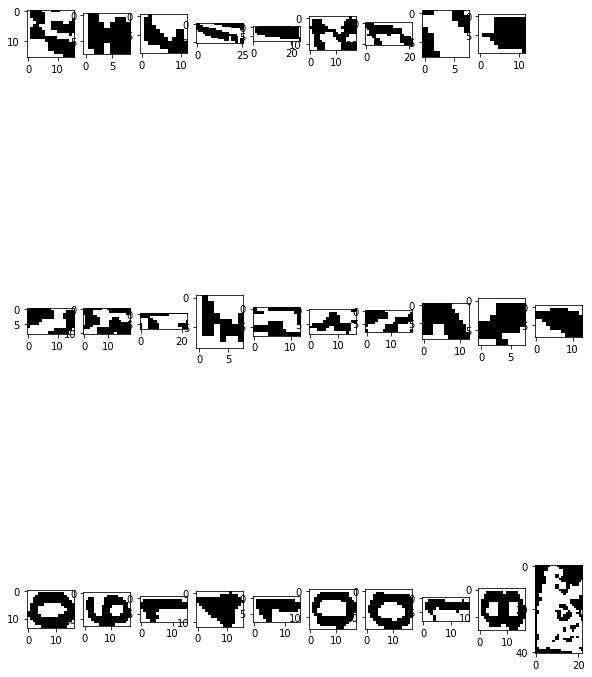

In [96]:
fig = plt.figure(figsize=(15, 15))

group = 0
for groupROICnts in ROICnts:
    contourIndex = 0
    for c in groupROICnts:
        contourIndex += 1
        a = fig.add_subplot(groupCount, 15, group * 15 + contourIndex)
        clone = np.dstack([thresholded.copy()] * 3)
        (x, y, w, h) = cv2.boundingRect(c)
        imgplot = plt.imshow(cv2.cvtColor(clone[y:y+h, x:x+w], cv2.COLOR_BGR2RGB))
    group += 1

plt.show()